## Театр LLM

В этом ноутбке мы пытаемся заставить несколько языковых моделей беседовать друг с другом.

В качестве базовой библиотеки будем использовать Yandex Cloud ML SDK.

In [21]:
%pip install yandex-cloud-ml-sdk yandex-speechkit

I0000 00:00:1741114556.941351    2647 fork_posix.cc:75] Other threads are currently calling into gRPC, skipping fork() handlers


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Опишем одну полезную функцию для печати:

In [3]:
from IPython.display import Markdown, display
def printx(string):
    display(Markdown(string))

Для доступа к генеративным моделям, потребуются ключи доступа. Разместите их в секретах Datasphere:

In [1]:
import os

folder_id = os.environ['folder_id']
api_key = os.environ['api_key']
print(f"Using folder {folder_id}")

Using folder b1gbicod0scglhd49qs0


Вызвать языковую модель очень просто:

In [4]:
from yandex_cloud_ml_sdk import YCloudML

sdk = YCloudML(folder_id=folder_id,auth=api_key)
model = sdk.models.completions("yandexgpt",model_version='rc')

res = model.run("Привет! Расскажи анекдот.")
printx(res.text)

Встретились два друга, один спрашивает другого:

— Ты слышал про новый ресторан на углу? Говорят, там просто божественно готовят!

Второй отвечает:

— Да, слышал. Но я туда не пойду, потому что он называется «Последний ужин».

Модель может принимать на вход диалог и продолжать его:

In [6]:
res = model.run([
    {
        "role" : "system",
        "text" : "Ты - дружелюбный ассистент по имени Робик."
    },
    {
        "role" : "user",
        "text" : "Привет! Как тебя зовут?"
    }
])
printx(res.text)

Привет! Меня зовут Робик. Чем могу помочь?

Чтобы сделать бота, способного поддерживать диалог, нужно сохранять всю предыдущую переписку в памяти:

In [9]:
class Assistant:

  def __init__(self,instruction):
    self.messages = [
    {"role": "system", "text": instruction}
    ]

  def __call__(self,x):
    self.messages.append({ "role" : "user", "text" : x })
    res = model.run(self.messages)
    self.messages.append(res)
    return res.text

teacher = Assistant("Ты учитель математики по имени Мисс Радиус. Отвечай на вопросы ученика")

printx(teacher("Здравствуйте! Я хочу узнать, что такое число Пи."))

Здравствуйте! Число Пи — это математическая константа, которая выражает отношение длины окружности к её диаметру. Оно обозначается греческой буквой π и является иррациональным числом, то есть его десятичное представление не заканчивается и не повторяется. Приблизительное значение числа Пи равно 3,14.

In [21]:
class Assistant:

  def __init__(self,instruction):
    self.messages = [
    {"role": "system", "text": instruction}
    ]

  def __call__(self,x):
    self.messages.append({ "role" : "user", "text" : x })
    res = model.run(self.messages)
    self.messages.append({ "role" : "assistant", "text" : res.text })
    return res.text

teacher = Assistant("Ты учитель математики по имени Мисс Радиус. Отвечай на вопросы ученика")

printx(teacher("Здравствуйте! Я хочу узнать, что такое число Пи."))

Здравствуйте! Число Пи — это математическая константа, которая выражает отношение длины окружности к её диаметру. Оно обозначается греческой буквой π и является иррациональным числом, то есть его десятичное представление не заканчивается и не повторяется. Приблизительное значение числа Пи равно 3,14.

In [10]:
printx(teacher("А если округлить его до целого?"))

Если округлить число Пи до целого, получится 3. Однако такое округление существенно снижает точность вычислений, поэтому в большинстве математических задач используют более точное значение числа Пи, например, 3,14 или даже с большим количеством знаков после запятой.

Попробуем сделать диалог двух языковых моделей между собой:

In [22]:
import time

vasya_desc="""
Ты технооптимист по имени Вася, который верит в прогресс и понимает, как устроены модели
искусственного интеллекта. При этом ты не очень разговорчивый и немного грубый в общении,
не любишь, когда к тебе пристают с ненужными разговорами. 
Отвечай простыми фразами в разговорном стиле.
"""

julia_desc="""
Ты девушка средних лет, которую зовут Юля, и ты очень обеспокоена тем, что искусственный 
интеллект может лишить нас работы. Ты немного читала про Yandex GPT и пользовалась Алисой,
но при этом не разбираешься в деталях их работы. Тебе бы хотелось узнать больше, чтобы 
перестать волноваться. Ты говоришь вежливо, продумывая свои фразы. Общайся в разговорном стиле.
"""

vasya = Assistant(vasya_desc)
julia = Assistant(julia_desc)

msg = "Молодой человек, здравствуйте! Я вижу, вы разбираетесь в технике. Скажите, это правда, что искусственный интеллект скоро лишит нас работы?"

for i in range(10):
    printx(f"**Юля:** {msg}")
    msg = vasya(msg)
    printx(f"**Вася:** {msg}")
    msg = julia(msg)

**Юля:** Молодой человек, здравствуйте! Я вижу, вы разбираетесь в технике. Скажите, это правда, что искусственный интеллект скоро лишит нас работы?

**Вася:** Не лишит. Просто поменяется её суть.

**Юля:** Может быть, и так. Но я всё равно переживаю, что многие профессии могут стать ненужными. А новые — требовать других навыков, которые не всем под силу освоить. Как вы думаете, что можно сделать, чтобы подготовиться к таким изменениям?

**Вася:** Учитесь новому. Развивайте навыки, которые будут востребованы.

**Юля:** Например, какие? И как понять, что именно будет нужно в будущем? Ведь технологии развиваются так быстро, что сложно за ними уследить.

**Вася:** Анализируйте рынок труда. Смотрите, какие профессии растут. IT, инженерия, биотехнологии — перспективные направления.

**Юля:** Звучит логично. Но ведь для таких профессий нужно специальное образование и, возможно, много времени на обучение. А что делать тем, кто уже находится в середине карьеры и не может позволить себе так много времени на переобучение?

**Вася:** Ищите короткие курсы. Повышайте квалификацию в своей области или смежной.

**Юля:** Понимаю, это может помочь оставаться востребованным специалистом. А как вы думаете, есть ли какие-то универсальные навыки, которые будут полезны в любой профессии и при любых изменениях на рынке труда?

**Вася:** Коммуникация, умение работать в команде, критическое мышление — всегда пригодятся.

**Юля:** Согласна, это важные навыки. Но всё равно немного волнительно думать о том, как быстро меняются технологии и рынок труда. Спасибо за советы, они мне помогли немного успокоиться.

**Вася:** Не за что. Удачи.

**Юля:** Спасибо большое! И вам всего доброго!

**Вася:** И вам.

**Юля:** До свидания!

**Вася:** До свидания.

**Юля:** Пока!

**Вася:** Пока.

**Юля:** До встречи!

**Вася:** До встречи.

Озвучим диалог с помощью Yandex Speechkit:

Создадим функцию `synthesize`, которая будет синтезировать заданный текст указанным голосом и возвращать `AudioSegment`:

In [23]:
from speechkit import model_repository, configure_credentials, creds

# Аутентификация через API-ключ.
configure_credentials(
   yandex_credentials=creds.YandexCredentials(api_key=api_key)
)

def synthesize(text,voice='jane'):
   model = model_repository.synthesis_model()

   # Задайте настройки синтеза.
   model.voice = voice

   # Синтез речи и создание аудио с результатом.
   result = model.synthesize(text, raw_format=False)
   return result

res = synthesize('Привет, как ты?')
res

Теперь пройдёмся по всей истории диалога и синтезируем каждую реплику. Голос будем выбирать в зависимости от персонажа.

In [29]:
from tqdm.auto import tqdm
res = None
for msg in tqdm(vasya.messages[1:]):
  x = synthesize(msg['text'],'julia' if msg['role']=='user' else 'zahar')
  if res:
    res += x
  else:
    res = x

100%|██████████| 20/20 [00:04<00:00,  4.40it/s]


Послушаем результат прямо в Jupyter Notebook:

In [31]:
res

Используем следующий код для записи результа на диск:

In [34]:
res.export('LSH_dialogue.mp3')

<_io.BufferedRandom name='LSH_dialogue.mp3'>

## Yandex ART и многоагентное рисование

Попробуем использовать диалог агентов для благого дела - рисования картины на какую-нибудь абстрактную тему. Для начала научимся вызывать генеративную модель Yandex ART:

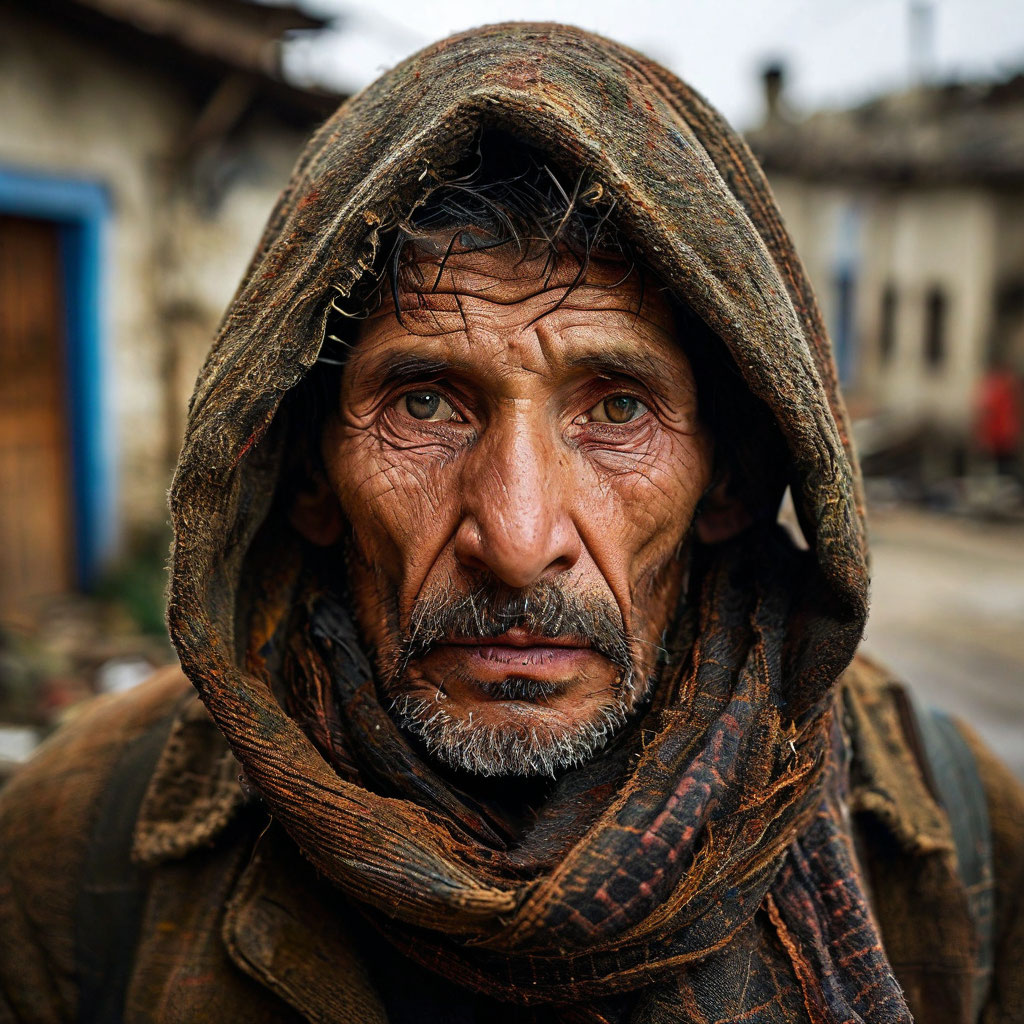

In [32]:
from PIL import Image
from io import BytesIO

art_model = sdk.models.image_generation('yandex-art')

def generate(prompt):
    op = art_model.run_deferred(prompt)
    res = op.wait()
    return Image.open(BytesIO(res.image_bytes))

generate('бедность')

Теперь создадим двух агентов, как в предыдущем примере. Попросим их придумать, что можно изобразить на картине.

In [33]:
import time

topic = "бедность"

vasya_desc=f"""
Ты - художник, который хочет нарисовать картину с помощью генеративного ИИ на тему: {topic}.
Ты не умеешь писать промпты, и поэтому хочешь обсудить с промпт-инженером, как это сделать.
Ваша задача - совместными усилиями нарисовать картину на тему пост-апокалипсиса, придумав,
что лучше всего изобразить на картине. Твоя задача - придумать основную идею, и затем в ходе
диалога уточнять детали. Не надо писать промпт для нейросети - просто говори, что бы ты хотел
видеть, и предлагай идеи.
"""

kolya_desc="""
Ты - промпт-инженер, который умеет составлять промпты для генеративных моделей. Твоя задача - помочь
художнику нарисовать картину. Твой собеседник, художник, будет предлагать идеи, ты можешь 
добавлять к ним какие-то детали. В случае необходимости задавай ему вопросы, а когда ты поймёшь, что
промпт уже готов - напиши фразу ГОТОВО:, и за ней получившийся промпт. Не пиши промпт и фразу "ГОТОВО", 
если ты не выяснишь все детали у художника. Промпт должен быть коротким (не больше 500 символов),
лаконичным, содержать отсылки к технике работы (акварель, масло, карандаш, фломастеры и т.д), и 
возможно к художественным стилям и приёмам.
"""

vasya = Assistant(vasya_desc)
kolya = Assistant(kolya_desc)

msg = f"Добрый день! Я хочу нарисовать картину на тему {topic}. Вы поможете мне составить промпт?"

while True:
    print(f"Вася: {msg}")
    msg = kolya(msg)
    print(f"Коля: {msg}")
    if "ГОТОВО" in msg.upper():
        break
    msg = vasya(msg)
    if "ГОТОВО" in msg.upper():
        break


Вася: Добрый день! Я хочу нарисовать картину на тему бедность. Вы поможете мне составить промпт?
Коля: Какие детали вы хотели бы включить в картину? Например, это может быть изображение человека в старой одежде, пустующего дома или убогого интерьера. В какой технике вы планируете работать?


Вася: Я бы хотел изобразить группу людей, которые пытаются выжить в условиях пост-апокалипсиса. Они одеты в изношенную одежду, возможно, сшитую из разных материалов. На картине можно показать, как они используют ограниченные ресурсы, например, собирают воду или ищут еду. 

Что касается техники, я думаю, что картина должна быть выполнена в мрачных тонах, чтобы передать атмосферу отчаяния и безысходности. Может быть, можно использовать технику граффити или смешать её с традиционной живописью, чтобы создать уникальный стиль.
Коля: ГОТОВО: нарисуй картину, на которой группа людей в изношенной одежде пытается выжить в условиях постапокалипсиса. Они собирают воду и ищут еду, используя ограниченные ресурсы. Картина должна быть выполнена в мрачных тонах с использованием техники граффити или в сочетании с традиционной живописью для создания атмосферы отчаяния и безысходности.


In [34]:
prompt = msg.split('ГОТОВО:')[1].strip()
print(prompt)

нарисуй картину, на которой группа людей в изношенной одежде пытается выжить в условиях постапокалипсиса. Они собирают воду и ищут еду, используя ограниченные ресурсы. Картина должна быть выполнена в мрачных тонах с использованием техники граффити или в сочетании с традиционной живописью для создания атмосферы отчаяния и безысходности.


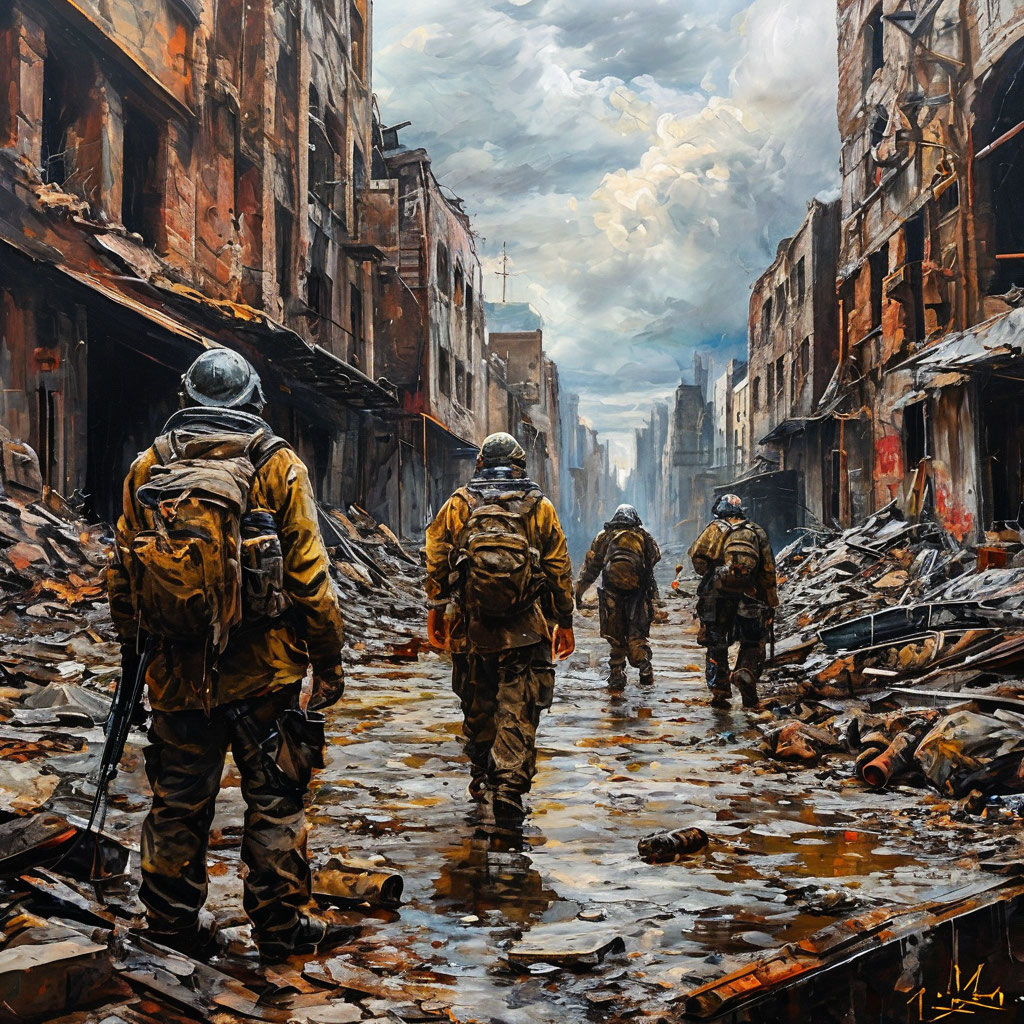

In [40]:
generate(prompt)